In [33]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from struct import unpack
from osgeo import gdal
import numpy as np
import pandas as pd
import os
# from mpl_toolkits.basemap import Basemap, cm
from datetime import datetime,timedelta
from netCDF4 import Dataset
import gzip
import shutil
import tqdm
from ftplib import FTP
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import contextily as ctx
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
import xarray as xr

In [3]:
import numpy as np
import pandas as pd
import urllib.request
import sys

In [17]:
def extract_precp_perssian(BinaryFile,lon_min,lon_max,lat_min,lat_max,time, path_output,time_step):
    
    "BinaryFile----> archivo de pricipitación en formato .bin"
    "lon_min---> longitud mínima de la cuadrícula de recorte"
    "lat_min---> latitud mínima de la cuadrícula de recorte"
    "lon_max---> longitud máxima de la cuadrícula de recorte"
    "lat_max---> latitud máxima de la cuadrícula de recorte"
    "time-----> fecha concreta del fichero que se desea recortar"
    "name_file----> nombre del fichero netCDF de salida"
    "path_output----> path donde se desa guardar el fichero"
    "time_step------> resolución temporal de los datos de entrada 1h, 6h, 1d"
    
    # import libraries
    import matplotlib.pyplot as plt
    import numpy as np
    from struct import unpack
    from osgeo import gdal


    # inputfile
    BinaryFile =  BinaryFile # '3B42_daily.2009.05.31.7.bin'. Make sure you adjust the location.

    # open binary file

    # set file dimensions
    xs = 9000
    ys = 3000
    originy = 60
    originx  = -180
    pixelsize = 0.04

    # set number of bytes in file
    NumbytesFile = xs * ys
     
    # number of columns in row
    NumElementxRecord = -xs
    
    myarr = []
    
    xx = np.linspace(originx, originx + (xs-1)*pixelsize, xs)
    yy = np.linspace(-originy, -originy + (ys-1)*pixelsize, ys)

    if time_step!='1d':
        with open(BinaryFile, "rb") as fidin:
            datos = np.fromfile(fidin, dtype='>H')
    else:
        with open(BinaryFile, "rb") as fidin:
            datos = np.fromfile(fidin, dtype='>f')

    fidin.close()
    del fidin


    matriz = np.transpose(datos.reshape((9000,3000), order="F"))
    myarr= np.flipud(matriz)
    posi_xx_right=np.where(xx<0)
    posi_xx_left=np.where(xx>=0)
    myarr=np.concatenate((myarr[:,posi_xx_left[0]],myarr[:,posi_xx_right[0]]), axis=1)
    myarr = myarr.astype(float)
    if time_step!='1d':
        myarr = myarr/100
    myarr[myarr < 0] = np.nan
    myarr[myarr == 555.370] = np.nan
    myarr = myarr[::-1]
    

    # Array to numpy float
    myarr = np.array(myarr).astype('float')
    # set coordinates
    posi_xx=np.where((xx>=lon_min)&(xx<=lon_max))
    posi_yy=np.where((yy>=lat_min)&(yy<=lat_max))
    [XX,YY]=np.meshgrid(xx[posi_xx[0]],yy[posi_yy[0]])
    #[XX,YY]=np.meshgrid(xx,yy)
    xx=xx[posi_xx[0]]
    yy=yy[posi_yy[0]]
    myarr=myarr[posi_yy[0],:]
    myarr=myarr[:,posi_xx[0]]
    def create_netcdf(precip,xx,yy, path_output,time,time_step):
        d=datetime.strptime(time,'%Y-%m-%d %H:%M:%S' )
        d=d.strftime('%Y_%m_%d_%Hh')
        nc = Dataset(path_output + 'rgccs_'+time_step+'_'+d+'.nc', 'w', format='NETCDF4')
        nc.description= 'Contiene los datos de precipitación PERSSIAN' 
        # nc dimensions
        nc.createDimension('lon',  len(xx))
        nc.createDimension('lat',  len(yy))
        nc.createDimension('time',1)
         # crear variables
        xx_nc=nc.createVariable('lon','float64', ('lon'))
        yy_nc=nc.createVariable('lat','float64', ('lat'))
        time_nc=nc.createVariable('time','float64',('time'))
        Prcp_nc=nc.createVariable('prcp','float64', ('time','lat', 'lon'))
        #units
        xx_nc.units = 'degrees_east'
        yy_nc.units = 'degrees_north'
        time_nc.units='hours since '+time
        Prcp_nc.units='mm'
        #long_name
        xx_nc.long_name = 'longitude coordinate'
        yy_nc.long_name = 'latitud coordinate'
        time_nc.long_name='dias del año'
        Prcp_nc.long_name='Precipitacion diaria'
        #fill_value
        Prcp_nc.missing_value='-9999'
        # calendar
        time_nc.calendar = 'proleptic_gregorian'
        xx_nc[:]=xx
        yy_nc[:]=sorted(yy,reverse=True)
        time_nc[:]=np.arange(0,1,1)
        Prcp_nc[:]=precip[:,:]
        nc.close()
    create_netcdf(myarr,xx,yy, path_output,time,time_step)

In [22]:
def download_daily(time_ini,time_fin,lon_min,lon_max,lat_min,lat_max,path_output):
    tini= pd.Series(pd.to_datetime(time_ini))
    tend=pd.Series(pd.to_datetime(time_fin))
    day_ini=tini.dt.dayofyear
    day_end=tend.dt.dayofyear
    time_step = '1d'
    time_step_p = 'daily'
    for yy,y in enumerate(tqdm.tqdm(pd.date_range(start=time_ini+' 00:00', end=time_fin+' 23:00', freq=time_step))):
        t= pd.Series(pd.to_datetime(y))
        d=t.dt.dayofyear[0]
        if time_step_p=='daily':
            url0 = 'ftp://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/'+time_step_p+'/rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin.gz'
        if os.path.exists(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.nc')==True:
            continue
        else:
            print('Descargando : '+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin.gz')
            not_downloaded = True
            nnn=0
            while not_downloaded:
                try:
                    urllib.request.urlretrieve(url0, path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin.gz')
                    with gzip.open(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin.gz', 'r') as f_in,\
                    open(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin', 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                    os.remove(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin.gz')
                    extract_precp_perssian(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin',\
                                   lon_min,lon_max,lat_min,lat_max,str(y), path_output,time_step)
                    os.remove(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+'.bin')
                    not_downloaded = False
                except:
                    print("Try again...")
                    nnn=nnn+1
                    if nnn>15:
                        print('No se descarga el modelo: ')
                        not_downloaded = False

In [23]:
def download_hourly(time_ini,time_fin,lon_min,lon_max,lat_min,lat_max,path_output):
    tini= pd.Series(pd.to_datetime(time_ini))
    tend=pd.Series(pd.to_datetime(time_fin))
    day_ini=tini.dt.dayofyear
    day_end=tend.dt.dayofyear
    time_step = '1h'
    time_step_p = 'hrly'
    for yy,y in enumerate(tqdm.tqdm(pd.date_range(start=time_ini+' 00:00', end=time_fin+' 23:00', freq=time_step))):
        t = pd.Series(pd.to_datetime(y))
        d = t.dt.dayofyear[0]
        url0 = 'ftp://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/'+time_step_p+'/'+str(y.year)+'/rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin.gz'
        if os.path.exists(path_output+'rgccs_'+time_step+'_'+str(y.year)+'_'+"{0:0=2d}".format(y.month)+'_'+"{0:0=2d}".format(d)+'_'+"{0:0=2d}".format(y.hour)+'h.nc')==True:
            continue
        else:
            print('Descargando : '+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin.gz')
            not_downloaded = True
            nnn=0
            while not_downloaded:
                try:
                    urllib.request.urlretrieve(url0, path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin.gz')
                    with gzip.open(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin.gz', 'r') as f_in,\
                    open(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin', 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        
                    f_in.close();f_out.close()
                    os.remove(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin.gz')
                    extract_precp_perssian(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin',\
                                   lon_min,lon_max,lat_min,lat_max,str(y), path_output,time_step)
                    os.remove(path_output+'rgccs'+time_step+str(y.year)[2:]+"{0:0=3d}".format(d)+"{0:0=2d}".format(y.hour)+'.bin')
                    not_downloaded = False
                except:
                    print("Try again...")
                    nnn=nnn+1
                    if nnn>15:
                        print('No se descarga el modelo: ')
                        not_downloaded = False

In [14]:
time_ini='2003-01-01'
time_fin='2024-07-15'

lon_min=-10.5
lon_max=5
lat_min=24.5
lat_max=44.25

time_step = '1d'

path_output ='E:/GitHub/NEOPRENE/notebooks/auxiliary-materials/PERSSIAN/'

# download_daily(time_ini,time_fin,lon_min,lon_max,lat_min,lat_max,path_output)

In [2]:
import os
import pandas as pd
import urllib.request
import gzip
import shutil
import concurrent.futures
import tqdm
import numpy as np
from datetime import datetime
from netCDF4 import Dataset
import xarray as xr

def extract_precp_perssian(BinaryFile, lon_min, lon_max, lat_min, lat_max, time, path_output, time_step):
    xs = 9000
    ys = 3000
    originy = 60
    originx  = -180
    pixelsize = 0.04
    
    xx = np.linspace(originx, originx + (xs-1)*pixelsize, xs)
    yy = np.linspace(-originy, -originy + (ys-1)*pixelsize, ys)

    if time_step != '1d':
        with open(BinaryFile, "rb") as fidin:
            datos = np.fromfile(fidin, dtype='>H')
    else:
        with open(BinaryFile, "rb") as fidin:
            datos = np.fromfile(fidin, dtype='>f')

    matriz = np.transpose(datos.reshape((xs, ys), order="F"))
    myarr = np.flipud(matriz)
    posi_xx_right = np.where(xx < 0)
    posi_xx_left = np.where(xx >= 0)
    myarr = np.concatenate((myarr[:, posi_xx_left[0]], myarr[:, posi_xx_right[0]]), axis=1)
    myarr = myarr.astype(float)
    
    myarr[myarr < 0] = np.nan
    myarr[myarr == 555.370] = np.nan

    data_array = xr.DataArray(
    myarr,
    coords={
        'lat': yy,  # Coordenadas de y (asumiendo que las filas son constantes para y)
        'lon': xx,   # Coordenadas de x (asumiendo que las columnas son constantes para x)
    },
    dims=['lat', 'lon'],
    name='prcp')

    data_array = data_array.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

    create_netcdf(data_array, path_output, time, time_step)

def create_netcdf(data_array, path_output, time, time_step):
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    d = time.strftime('%Y_%m_%d_%Hh')
    nc_filename = os.path.join(path_output, f'rgccs_{time_step}_{d}.nc')
    
    data_array.attrs['description'] = 'Contiene los datos de precipitación PERSSIAN'
    data_array.attrs['units'] = 'mm'
    data_array.attrs['missing_value'] = -9999
    if time_step=='1d':
        data_array.attrs['long_name'] = 'Daily precipitation'
    elif time_step=='1h':
        data_array.attrs['long_name'] = 'Hourly precipitation'


    data_array['lat'].attrs['units'] = 'degrees_north'
    data_array['lat'].attrs['long_name'] = 'latitude coordinate'
    data_array['lon'].attrs['units'] = 'degrees_east'
    data_array['lon'].attrs['long_name'] = 'longitude coordinate'

    # Añadir la coordenada temporal
    data_array = data_array.expand_dims(time=[time])
    data_array.to_netcdf(nc_filename)


def download_and_process(url, output_path, lon_min, lon_max, lat_min, lat_max, date_str, time_step):
    retries = 15
    for attempt in range(retries):
        try:
            gzip_file = f'{output_path}.bin.gz'
            bin_file = f'{output_path}.bin'
            
            urllib.request.urlretrieve(url, gzip_file)
            with gzip.open(gzip_file, 'r') as f_in, open(bin_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(gzip_file)
            extract_precp_perssian(bin_file, lon_min, lon_max, lat_min, lat_max, date_str, path_output, time_step)
            os.remove(bin_file)
            return
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt + 1 == retries:
                print(f"Failed to download and process {url} after {retries} attempts.")
                return

def download_daily(time_ini, time_fin, lon_min, lon_max, lat_min, lat_max, path_output):
    tini = pd.to_datetime(time_ini)
    tend = pd.to_datetime(time_fin)
    time_step = '1d'
    time_step_p = 'daily'
    
    dates = pd.date_range(start=f'{time_ini} 00:00', end=f'{time_fin} 23:00', freq=time_step)
    
    tasks = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for y in tqdm.tqdm(dates):
            day_of_year = y.dayofyear
            year_short = str(y.year)[2:]
            date_str = y.strftime('%Y-%m-%d %H:%M:%S')
            filename = f'rgccs_{time_step}_{y.year}_{y.month:02d}_{y.day:02d}_00h'
            url = f'ftp://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/{time_step_p}/rgccs{time_step}{year_short}{day_of_year:03d}.bin.gz'
            output_path = os.path.join(path_output, filename)
            
            if os.path.exists(output_path + '.nc'):
                continue
            
            print(f'Descargando: {filename}.bin.gz')
            tasks.append(executor.submit(download_and_process, url, output_path, lon_min, lon_max, lat_min, lat_max, date_str, time_step))
    
    for task in tasks:
        task.result()

def download_hourly(time_ini, time_fin, lon_min, lon_max, lat_min, lat_max, path_output):
    tini = pd.to_datetime(time_ini)
    tend = pd.to_datetime(time_fin)
    time_step = '1h'
    time_step_p = 'hrly'
    
    dates = pd.date_range(start=f'{time_ini} 00:00', end=f'{time_fin} 23:00', freq=time_step)
    
    tasks = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for y in tqdm.tqdm(dates):
            day_of_year = y.dayofyear
            year_short = str(y.year)[2:]
            date_str = y.strftime('%Y-%m-%d %H:%M:%S')
            filename = f'rgccs_1h_{y.year}_{y.month:02d}_{y.day:02d}_{y.hour:02d}h'
            url = f'ftp://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/{time_step_p}/{y.year}/rgccs{time_step}{year_short}{day_of_year:03d}{y.hour:02d}.bin.gz'
            output_path = os.path.join(path_output, filename)
            
            if os.path.exists(output_path + '.nc'):
                continue
            
            print(f'Descargando: {filename}.bin.gz')
            tasks.append(executor.submit(download_and_process, url, output_path, lon_min, lon_max, lat_min, lat_max, date_str, time_step))
    
    for task in tasks:
        task.result()


time_ini='2003-01-01'
time_fin='2024-07-15'

lon_min=-10.5
lon_max=5
lat_min=24.5
lat_max=44.25

time_step = '1d'

path_output ='E:/GitHub/NEOPRENE/notebooks/auxiliary-materials/PERSSIAN/'

# Ejemplo de llamada a la función
download_daily(time_ini, time_fin, lon_min, lon_max, lat_min, lat_max, path_output)


100%|██████████| 7867/7867 [00:00<00:00, 28193.56it/s]


Descargando: rgccs_1d_2024_03_05_00h.bin.gz
Descargando: rgccs_1d_2024_03_06_00h.bin.gz
Descargando: rgccs_1d_2024_03_07_00h.bin.gz
Descargando: rgccs_1d_2024_03_08_00h.bin.gz
Descargando: rgccs_1d_2024_03_09_00h.bin.gz
Descargando: rgccs_1d_2024_03_19_00h.bin.gz
Descargando: rgccs_1d_2024_04_14_00h.bin.gz
Descargando: rgccs_1d_2024_04_15_00h.bin.gz
Descargando: rgccs_1d_2024_04_16_00h.bin.gz
Descargando: rgccs_1d_2024_04_17_00h.bin.gz
Descargando: rgccs_1d_2024_04_18_00h.bin.gz
Descargando: rgccs_1d_2024_04_19_00h.bin.gz
Descargando: rgccs_1d_2024_04_20_00h.bin.gz
Attempt 1 failed: <urlopen error ftp error: URLError("ftp error: error_perm('550 Failed to change directory.')")>
Attempt 1 failed: <urlopen error ftp error: URLError("ftp error: error_perm('550 Failed to change directory.')")>
Attempt 1 failed: <urlopen error ftp error: URLError("ftp error: error_perm('550 Failed to change directory.')")>
Attempt 1 failed: <urlopen error ftp error: URLError("ftp error: error_perm('550 Faile

In [49]:
time_step = '1d'
BinaryFile = './auxiliary-materials/PERSSIAN/rgccs1d03001.bin'
# set file dimensions
xs = 9000
ys = 3000
originy = 60
originx  = -180
pixelsize = 0.04

# set number of bytes in file
NumbytesFile = xs * ys
    
# number of columns in row
NumElementxRecord = -xs

myarr = []

xx = np.linspace(originx, originx + (xs-1)*pixelsize, xs)
yy = np.linspace(-originy, -originy + (ys-1)*pixelsize, ys)

if time_step!='1d':
    with open(BinaryFile, "rb") as fidin:
        datos = np.fromfile(fidin, dtype='>H')
else:
    with open(BinaryFile, "rb") as fidin:
        datos = np.fromfile(fidin, dtype='>f')

fidin.close()
del fidin


matriz = np.transpose(datos.reshape((9000,3000), order="F"))
myarr= np.flipud(matriz)
posi_xx_right=np.where(xx<0)
posi_xx_left=np.where(xx>=0)
myarr=np.concatenate((myarr[:,posi_xx_left[0]],myarr[:,posi_xx_right[0]]), axis=1)
myarr = myarr.astype(float)
myarr[myarr < 0] = np.nan
myarr[myarr == 555.370] = np.nan

data_array = xr.DataArray(
    myarr,
    coords={
        'y': yy,  # Coordenadas de y (asumiendo que las filas son constantes para y)
        'x': xx,   # Coordenadas de x (asumiendo que las columnas son constantes para x)
    },
    dims=['y', 'x']
)
data_array = data_array.sel(x=slice(lon_min,lon_max),y=slice(lat_min,lat_max))


In [50]:
# Crear la máscara para valores menores de 0.5
mask = data_array < 0.5

# Aplicar la máscara: se establece a NaN
data_array_masked = data_array.where(~mask)

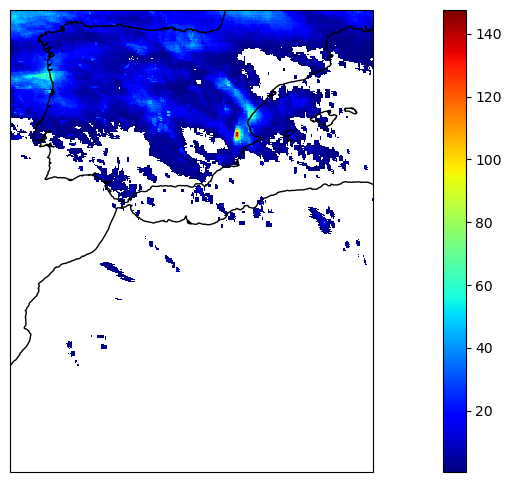

In [51]:
fig, axes = plt.subplots(figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')
data_array_masked.plot(ax=axes,cmap='jet')

In [31]:
lat_max

44.25

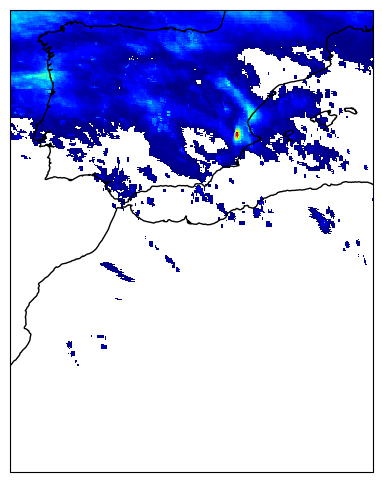

In [19]:
# Array to numpy float
myarr = np.array(myarr).astype('float')
# set coordinates
posi_xx=np.where((xx>=lon_min)&(xx<=lon_max))
posi_yy=np.where((yy>=lat_min)&(yy<=lat_max))
[XX,YY]=np.meshgrid(xx[posi_xx[0]],yy[posi_yy[0]])
#[XX,YY]=np.meshgrid(xx,yy)
xx=xx[posi_xx[0]]
yy=yy[posi_yy[0]]
myarr=myarr[posi_yy[0],:]
myarr=myarr[:,posi_xx[0]]
mask = myarr < 0.5
# Aplicar la máscara: se establece a NaN
myarr_masked_2 = np.ma.array(myarr, mask=mask)
fig, axes = plt.subplots(figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axes.pcolormesh(xx,yy,myarr_masked_2 ,cmap='jet')
axes.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, edgecolor='black')